## Evaluating 2001 to 2018 Chicago Crime Data Using PySpark

In [1]:
import platform
print(platform.python_version())

3.7.1


In [2]:
from pyspark.sql import SparkSession, types
from pyspark.sql.functions import to_timestamp, unix_timestamp, max as max_dttm
from pyspark.sql.types import *
spark = SparkSession.builder.appName('PySpark').getOrCreate()
print(spark.version)

2.4.0


### Create dataframe from csv and print the schema:

In [179]:
df = spark.read.csv('chicago_crimes_2001_to_present.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- xc: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated x: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Convert date to timestamp format for proper processing:

In [157]:
df = df.withColumn('dttm', unix_timestamp('Date', "MM/dd/yyyy hh:mm:ss aa").cast(TimestampType()))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- xc: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated x: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- dttm: timestamp (nullable = true)



### Rows and Columns of the DataFrame

In [161]:
print('Rows: ' + str(df.count()))
print('Cols: ' + str(len(df.columns)))

Rows: 6754279
Cols: 23


### Get Date Range of Occurences 

In [162]:
first_date = df.agg({"dttm":"min"}).collect()[0][0]
print('First Date: ' + str(first_date))

last_date = df.agg({"dttm":"max"}).collect()[0][0]
print('Last Date: ' + str(last_date))

First Date: 2001-01-01 00:00:00
Last Date: 2018-11-22 23:56:00


### Year Operations

In [164]:
from pyspark.sql.functions import year, countDistinct

# get total years from main data frame
total_years = df.agg(countDistinct(year('dttm'))).na.drop().collect()[0][0]
print('Total Years: ' + str(total_years))

per_year = df.select(year('dttm').alias('year')).groupBy('year').count().orderBy('year').na.drop()
per_year.show()

# get total years if you pull out a seperate dataframe
print('Total Years: ' + str(per_year.count()))

Total Years: 18
+----+------+
|year| count|
+----+------+
|2001|485738|
|2002|486742|
|2003|475923|
|2004|469366|
|2005|453686|
|2006|448078|
|2007|436986|
|2008|427024|
|2009|392649|
|2010|370277|
|2011|351736|
|2012|335908|
|2013|307020|
|2014|275196|
|2015|263930|
|2016|268814|
|2017|267811|
|2018|237148|
+----+------+

Total Years: 18


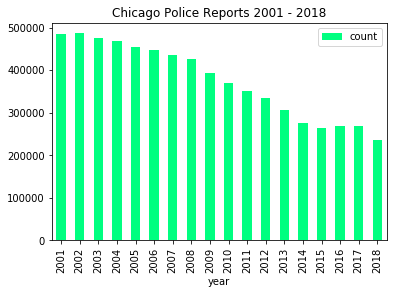

In [178]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

per_year = df.select(year('dttm').alias('year')).groupBy('year').count().orderBy('year', ascending=True).na.drop()

per_year_pandas_df = per_year.toPandas()
per_year_pandas_df.plot(kind='bar',x='year',y='count',colormap='winter_r', title='Chicago Police Reports 2001 - 2018')

In [39]:
import timeit
start_time = timeit.default_timer()

max_year_value = per_year.agg({"count":"max"}).collect()[0][0]
max_year = per_year.filter(per_year['count'] == max_year_value).select('year').collect()[0][0]
print('Max Year: ' + str(max_year) + ' | ' + str(max_year_value))

# min crimes in a year
min_year_value = per_year.agg({"count":"min"}).collect()[0][0]
min_year = per_year.filter(per_year['count'] == min_year_value).select('year').collect()[0][0]
print('Min Year: ' + str(min_year) + ' | ' + str(min_year_value))

elapsed = timeit.default_timer() - start_time
print('Time to get Max and min value: ' + str(elapsed))

# average crimes in a year
avg_year_value = per_year.agg({"count":"avg"}).collect()[0][0]
print('Avg Year: ' + str(avg_year_value))

Max Year: 2002 | 486742
Min Year: 2018 | 237148
Time to get Max and min value: 76.90986901500037
Avg Year: 375224.0


In [172]:
import timeit

start_time = timeit.default_timer()
# code you want to evaluate

per_year = per_year.orderBy('count', ascending=False)
max_value = per_year.head()
print(max_value)

per_year = per_year.orderBy('count', ascending=True)
min_value = per_year.head()
print(min_value)

elapsed = timeit.default_timer() - start_time
print('Time to get Max and min value: ' + str(elapsed))


Row(year=2002, count=486742)
Row(year=2018, count=237148)
Time to get Max and min value: 39.71179824899809


In [118]:
from pyspark.sql.functions import year, month, dayofmonth, lit, concat
from datetime import datetime, timedelta
from pyspark.sql.types import StringType

per_date = df.withColumn('YYYY/MM/DD', 
                         concat(
                             year('dttm').cast(StringType()),
                             lit("/"),
                             month('dttm').cast(StringType()),
                             lit("/"),
                             dayofmonth('dttm').cast(StringType())))\
    .groupBy('YYYY/MM/DD')\
    .count()\
    .orderBy('count', ascending=False)\
    .na.drop()

print('Total Days: ' + str(per_date.count()))

per_date.show()

max_value = per_date.head()
print('Most: ' + str(max_value[0]) + ' | ' + str(max_value[1]))

per_date = per_date.orderBy('count', ascending=True)
per_date.show()

min_value = per_date.head()
print('Least: ' + str(min_value[0]) + ' | ' + str(min_value[1]))

avg_day_value = per_date.agg({"count":"avg"}).collect()[0][0]
print('Avg: ' + str(avg_day_value))


Total Days: 6535
+----------+-----+
|YYYY/MM/DD|count|
+----------+-----+
|  2003/1/1| 2023|
|  2005/1/1| 1961|
|  2007/1/1| 1946|
|  2006/1/1| 1901|
|  2004/1/1| 1890|
|  2002/1/1| 1854|
|  2009/1/1| 1818|
|  2001/1/1| 1815|
|  2008/1/1| 1801|
|  2002/6/1| 1782|
| 2002/10/1| 1763|
|2003/10/17| 1751|
| 2001/11/1| 1736|
| 2001/10/1| 1707|
|2003/10/16| 1701|
|  2004/6/1| 1698|
|  2002/8/1| 1688|
| 2003/8/21| 1683|
|  2001/6/1| 1660|
| 2003/11/1| 1655|
+----------+-----+
only showing top 20 rows

Most: 2003/1/1 | 2023
+----------+-----+
|YYYY/MM/DD|count|
+----------+-----+
|  2011/2/2|  320|
|  2014/1/6|  365|
|2017/12/25|  394|
|  2014/1/5|  404|
|2013/12/25|  425|
|2014/12/25|  438|
|  2015/1/8|  447|
|2014/11/27|  453|
| 2015/2/19|  463|
|  2014/1/7|  466|
|  2015/2/2|  469|
| 2017/3/14|  470|
|  2015/1/7|  473|
|  2014/1/2|  482|
|2016/12/25|  487|
|2018/11/22|  493|
|2015/12/25|  498|
|2017/12/24|  501|
|  2015/1/6|  502|
|2010/12/25|  503|
+----------+-----+
only showing top 20 row

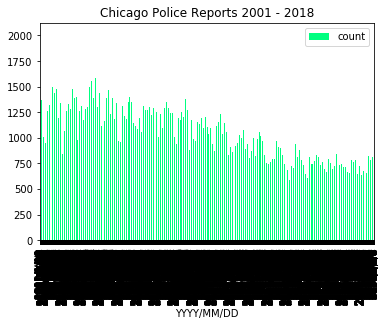

In [176]:
per_date = df.withColumn('YYYY/MM/DD', 
                         concat(
                             year('dttm').cast(StringType()),
                             lit("/"),
                             month('dttm').cast(StringType()),
                             lit("/"),
                             dayofmonth('dttm').cast(StringType())))\
    .groupBy('YYYY/MM/DD')\
    .count()\
    .orderBy('YYYY/MM/DD', ascending=True)\
    .na.drop()

per_date_pandas_df = per_date.toPandas()
per_date_pandas_df.plot(kind='bar',x='YYYY/MM/DD',y='count',colormap='winter_r', title='Chicago Police Reports 2001 - 2018')

In [120]:
from pyspark.sql.functions import year, month, dayofmonth, lit, concat
from datetime import datetime, timedelta
from pyspark.sql.types import StringType

per_month = df.withColumn('YYYY/MM', 
                         concat(
                             year('dttm').cast(StringType()),
                             lit("/"),
                             month('dttm').cast(StringType())))\
    .groupBy('YYYY/MM')\
    .count()\
    .orderBy('count', ascending=False)\
    .na.drop()

print('Total Months: ' + str(per_month.count()))

per_month.show()

max_value = per_month.head()
print('Most: ' + str(max_value[0]) + ' | ' + str(max_value[1]))

per_month = per_month.orderBy('count', ascending=True)
per_month.show()

min_value = per_month.head()
print('Least: ' + str(min_value[0]) + ' | ' + str(min_value[1]))

avg_day_value = per_month.agg({"count":"avg"}).collect()[0][0]
print('Avg: ' + str(avg_day_value))


Total Days: 215
+-------+-----+
|YYYY/MM|count|
+-------+-----+
| 2002/7|46013|
| 2001/7|44691|
| 2003/8|44267|
| 2002/8|44210|
| 2001/8|44032|
| 2003/7|43415|
|2003/10|43327|
| 2004/7|43236|
|2002/10|43145|
| 2004/8|43044|
|2001/10|43028|
| 2002/5|42913|
| 2002/6|42834|
| 2002/9|42388|
| 2001/5|41821|
| 2005/7|41805|
| 2001/6|41724|
| 2006/7|41544|
| 2005/8|41543|
|2004/10|41523|
+-------+-----+
only showing top 20 rows

Most: 2002/7 | 46013
+-------+-----+
|YYYY/MM|count|
+-------+-----+
|2018/11|14475|
| 2015/2|16344|
| 2018/2|17207|
| 2014/2|18006|
| 2016/2|18680|
| 2017/2|19229|
| 2014/1|19970|
| 2018/1|20245|
|2016/12|20323|
| 2017/3|20481|
|2015/11|20548|
| 2016/1|20584|
|2014/11|20734|
| 2015/1|20831|
|2014/12|20953|
| 2018/4|20976|
|2017/12|21002|
| 2018/3|21073|
| 2016/4|21096|
|2015/12|21102|
+-------+-----+
only showing top 20 rows

Least: 2018/11 | 14475
Avg: 31414.102325581396


In [122]:
df_desc = df.select('Description').groupBy('Description').count().orderBy('count', ascending=False).na.drop()
df_desc.show()

+--------------------+------+
|         Description| count|
+--------------------+------+
|              SIMPLE|796955|
|      $500 AND UNDER|547562|
|DOMESTIC BATTERY ...|517862|
|          TO VEHICLE|375202|
|         TO PROPERTY|355215|
|           OVER $500|348830|
|POSS: CANNABIS 30...|276637|
|      FORCIBLE ENTRY|263149|
|          AUTOMOBILE|246469|
|       FROM BUILDING|227082|
|        RETAIL THEFT|167601|
|    TELEPHONE THREAT|134604|
|             TO LAND|119847|
|         POSS: CRACK|119151|
|      UNLAWFUL ENTRY|103049|
|HARASSMENT BY TEL...|100475|
|AGGRAVATED: OTHER...| 93369|
| POSS: HEROIN(WHITE)| 92069|
|      ARMED: HANDGUN| 90622|
|STRONGARM - NO WE...| 88800|
+--------------------+------+
only showing top 20 rows



In [128]:
df_desc = df.select('Primary Type').groupBy('Primary Type').count().orderBy('count', ascending=False).na.drop()
df_desc.show()

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1419778|
|             BATTERY|1233497|
|     CRIMINAL DAMAGE| 772203|
|           NARCOTICS| 711246|
|       OTHER OFFENSE| 419045|
|             ASSAULT| 418984|
|            BURGLARY| 388317|
| MOTOR VEHICLE THEFT| 314482|
|  DECEPTIVE PRACTICE| 262920|
|             ROBBERY| 255909|
|   CRIMINAL TRESPASS| 193555|
|   WEAPONS VIOLATION|  70811|
|        PROSTITUTION|  68343|
|PUBLIC PEACE VIOL...|  47810|
|OFFENSE INVOLVING...|  45404|
| CRIM SEXUAL ASSAULT|  27150|
|         SEX OFFENSE|  25123|
|INTERFERENCE WITH...|  15175|
|            GAMBLING|  14424|
|LIQUOR LAW VIOLATION|  14070|
+--------------------+-------+
only showing top 20 rows



In [136]:
df_desc = df.select('Community Area').groupBy('Community Area').count().orderBy('count', ascending=False).na.drop()
df_desc.show()

+--------------+------+
|Community Area| count|
+--------------+------+
|            25|391164|
|             8|209192|
|            43|200332|
|            23|194166|
|            24|181590|
|            67|180807|
|            28|180580|
|            29|176959|
|            71|173906|
|            68|164129|
|            49|164029|
|            66|152457|
|            69|151143|
|            32|144605|
|            44|131552|
|            22|129804|
|            61|127385|
|             6|121524|
|            27|116570|
|            46|114548|
+--------------+------+
only showing top 20 rows



### Percentage of Crimes that yielded arrests:

In [154]:
arrests_df = df.select('Arrest').groupBy('Arrest').count().orderBy('count', ascending=False).na.drop()
arrests_df.show()
did = arrests_df.filter(df_desc['Arrest'] == True).collect()[0]['count']
did_not = arrests_df.filter(df_desc['Arrest'] == False).collect()[0]['count']

print('Percentage Yielding in Arrests: ' + str(did/ (did + did_not)))


+------+-------+
|Arrest|  count|
+------+-------+
| false|4881385|
|  true|1872894|
+------+-------+

Percentage Yielding in Arrests: 0.27728999646002184


In [148]:
print(true_row['count'])
print(false_row['count'])
print(true_row['count'] + false_row['count'])

1872894
4881385
6754279


In [149]:
df_desc.sum().collect()[0][0]

AttributeError: 'DataFrame' object has no attribute 'sum'

In [134]:
df_desc = df.select('District').groupBy('District').count().orderBy('count', ascending=False).na.drop()
df_desc.show()

+--------+------+
|District| count|
+--------+------+
|       8|459613|
|      11|432097|
|       7|399052|
|      25|390049|
|       6|389092|
|       4|382973|
|       3|343284|
|       9|335911|
|      12|330829|
|       2|320825|
|      19|301079|
|       5|299419|
|      18|296962|
|      15|294830|
|      10|288800|
|      14|266438|
|       1|262820|
|      16|223538|
|      22|221413|
|      24|201375|
+--------+------+
only showing top 20 rows



In [129]:
df_desc = df.select('Location Description').groupBy('Location Description').count().orderBy('count', ascending=False).na.drop()
df_desc.show()

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1772181|
|           RESIDENCE|1143692|
|           APARTMENT| 698320|
|            SIDEWALK| 665936|
|               OTHER| 256698|
|PARKING LOT/GARAG...| 194002|
|               ALLEY| 151004|
|SCHOOL, PUBLIC, B...| 142334|
|    RESIDENCE-GARAGE| 131707|
|  SMALL RETAIL STORE| 119452|
|RESIDENCE PORCH/H...| 118042|
|VEHICLE NON-COMME...| 108339|
|          RESTAURANT| 105784|
|  GROCERY FOOD STORE|  87415|
|    DEPARTMENT STORE|  83783|
|         GAS STATION|  72073|
|RESIDENTIAL YARD ...|  69613|
|CHA PARKING LOT/G...|  55468|
|       PARK PROPERTY|  52346|
|COMMERCIAL / BUSI...|  49161|
+--------------------+-------+
only showing top 20 rows



In [126]:
max_lat = df.select('Latitude').orderBy('Latitude', ascending=False).na.drop().head()[0]
min_lat = df.select('Latitude').orderBy('Latitude', ascending=True).na.drop().head()[0]
print(max_lat)
print(min_lat)
max_lon = df.select('Longitude').orderBy('Longitude', ascending=False).na.drop().head()[0]
min_lon = df.select('Longitude').orderBy('Longitude', ascending=True).na.drop().head()[0]
print(max_lon)
print(min_lon)

42.022910333
36.619446395
-87.524529378
-91.686565684


In [181]:
df.rdd.getNumPartitions()

12

In [182]:
df.repartition(6).createOrReplaceTempView('sql_df')

In [191]:
# before cache - do count 
import timeit
start_time = timeit.default_timer()
print(df.count())
elapsed = timeit.default_timer() - start_time
print('Time to Count: ' + str(elapsed))

6754279
Time to Count: 5.345162611003616


In [185]:
df.rdd.getNumPartitions()
df.repartition(6).createOrReplaceTempView('sql_df')
spark.catalog.cacheTable('sql_df')

In [186]:
# next count will initiate cache and will take much longer
import timeit
start_time = timeit.default_timer()
spark.table('sql_df').count()
elapsed = timeit.default_timer() - start_time
print('Time to Count: ' + str(elapsed))

Time to Count: 98.62464690100023


In [187]:
# now create a dataframe that will operate on the cached version
df_cache = spark.table("sql_df")

In [192]:
# way quicker: 5x improvement on cached dataframe!!!!
import timeit
start_time = timeit.default_timer()
print(df_cache.count())
elapsed = timeit.default_timer() - start_time
print('Time to Count: ' + str(elapsed))

6754279
Time to Count: 1.6543181590022868


In [194]:
# check is table is cached
spark.catalog.isCached("sql_df")

True

In [195]:
# write out the dataframe
# df_cache.write.format('parquet').save('tmp/df_cache/')
# cant do that until we rename columns with spaces. 

# BUT THIS WRITE WILL PERSIST THE PARTITIONS AND STUFF

AnalysisException: 'Attribute name "Case Number" contains invalid character(s) among " ,;{}()\\n\\t=". Please use alias to rename it.;'